In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import pickle
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

# import libraries we'll use
import spacy # fast NLP
import pandas as pd # dataframes
import langid # language identification (i.e. what language is this?)
from nltk.classify.textcat import TextCat # language identification from NLTK

import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm
import joblib


pd.set_option("max_colwidth", 1000)

In [2]:
#Global variable
N_FOLDS=5 #Number of cross validation folds
use_catogerical_features=True  #False: Use only text data

In [3]:
#Read the data
df=pd.read_csv('../input/biding-dataset/CombinedData.csv')
#Drop rows with missing values
df=df.dropna().reset_index()

In [4]:
df.head()

,index,Unnamed: 0,Auction Name,Days,Date,Winning Bid,Starting Bid,Currency,Hierarchy,Category 1,Category 2
0,0,0,EICHHOLTZ Barwagen Trolley Townhouse Gold NP 1699€,7,17 Jan 2021 at 11:10:37am GMT,605.00,1.00,EUR,"Home, Furniture & DIY>Furniture>Drinks Trolleys & Tea Trolleys",Furniture,Drinks Trolleys & Tea Trolleys
1,1,1,CLEARANCE - HAMPTON GREY LEATHER 2 SEATER CHESTERFIELD SOFA - T9361,5,22 Feb 2021 at 9:25:58pm GMT,405.10,0.99,£,"Home, Furniture & DIY>Furniture>Sofas, Armchairs & Couches",Furniture,"Sofas, Armchairs & Couches"
2,2,2,"⚽ LARGE CHESTERFIELD FOOTSTOOL VELVET GREY SIZE 35"" X 35"" X H 16"" FREE UK POST",7,25 Jan 2021 at 8:16:23pm GMT,154.85,1.00,£,"Home, Furniture & DIY>Furniture>Ottomans & Footstools",Furniture,Ottomans & Footstools
3,3,3,Außergewöhnlicher Designstuhl sucht Liebhaber,10,31 Jan 2021 at 6:50:43pm GMT,921.85,1.00,EUR,"Home, Furniture & DIY>Furniture>Chairs",Furniture,Chairs
4,4,4,BAUHAUS Nachbau Barcelona Chair + Hocker im Design von Mies van der Rohe Leder!,10,7 Feb 2021 at 7:14:08pm GMT,632.00,1.00,EUR,"Home, Furniture & DIY>Furniture>Sofas, Armchairs & Couches",Furniture,"Sofas, Armchairs & Couches"


## Lower casing
We will create a new dataframe `df2` to save all our text preprocessing to compare the results of each step.
* We start by lower casing

In [5]:
df2=pd.DataFrame()
df2["text_lower"] = df["Auction Name"].str.lower()

## Remove punctuation

In [6]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df2["text_wo_punct"] = df2["text_lower"].apply(lambda text: remove_punctuation(text))

## Remove stopwords
We have many languages in this dataset: English, German, Italian and French. We will remove stop words for english and German.

In [7]:
from nltk.corpus import stopwords
#", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))
STOPWORDS2 = set(stopwords.words('german'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_stopwords2(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS2])

df2["text_wo_stop"] = df2["text_wo_punct"].apply(lambda text: remove_stopwords(text))
df2["text_wo_stop"] = df2["text_wo_stop"].apply(lambda text: remove_stopwords2(text))


## Lemmatizer
Lemmatizer helps to get to words into their original format, for example the verbs to the infinitif and the nouns are stripped from the prefixes and suffixes.

In [8]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df2["text_lemmatized"] = df2["text_wo_stop"].apply(lambda text: lemmatize_words(text))


## Porter Stemmer:
Porter Stemmer is the same as the lemmatizer, only a bit worse,included  here because  its in rapidminer file. Not using porter stemmer in modeling.

In [9]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df2["text_stemmed"] = df2["text_wo_stop"].apply(lambda text: stem_words(text))

# Remove emojis:
I noticed there are some emojis in some items likes DVDs and footballs. It's better to remove them.

In [10]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df2["remove_emoji"] = df2["text_lemmatized"].apply(lambda text: remove_emoji(text))

### The difference between the 6 text preprocessing steps:

In [11]:
df2.sample(1)

,text_lower,text_wo_punct,text_wo_stop,text_lemmatized,text_stemmed,remove_emoji
1023,sony svf1521q1ew 15.6 in laptop i5-3337u 1.80 ghz 4gb 750 gb hdd win 10 home,sony svf1521q1ew 156 in laptop i53337u 180 ghz 4gb 750 gb hdd win 10 home,sony svf1521q1ew 156 laptop i53337u 180 ghz 4gb 750 gb hdd win 10 home,sony svf1521q1ew 156 laptop i53337u 180 ghz 4gb 750 gb hdd win 10 home,soni svf1521q1ew 156 laptop i53337u 180 ghz 4gb 750 gb hdd win 10 home,sony svf1521q1ew 156 laptop i53337u 180 ghz 4gb 750 gb hdd win 10 home


# TfidVectorizer:
Finally; we have a clean text dataset ready to be converted to frequency vectors with TfidfVectorizer:

* n_grams= (1,4)
> We set n_grams= (1,4) to calculate the frequency of single words (1-gram), 2 words (2-gram), 3 words (3-grams) and 4 words.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 4), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

#pickle.dump(tfv, open('tfidVectorizer.pkl', 'wb'))


# Metric:
We set a function `score` to calculate the **metric RMSE**, which is a square root of the mean_squared_error.

In [13]:
def score(y_pred):
    return str(math.sqrt(sklm.mean_squared_error(y_test, y_pred)))

# Cross validation strategy:
Here we will split the data to k FOLDs for cross validation **based on 'category 1'**:
* The idea is that some items that belong to the **category: furniture** don't cost the same as the items that belong the **category:DVD/Films**. So if we split the data to 5 folds where 1 fold only has DVD/Films rows in validation and furniture in training, the validation score will be bad because the model is validated on a DVD item while it was trained on a furniture item.
* The problem is that we have 94 categories in 'Category 1' *(Which is a lot)*:

In [14]:
print('Number of categories in category 1:')
len(df['Category 1'].unique())

Number of categories in category 1:


94

Out of those 94 categories, only 15 categories have more than 40 items:

In [15]:
df['Category 1'].value_counts()[:15]

DVDs, Films & TV                   1002
Furniture                           859
Watches                             838
Laptops & Netbooks                  524
Fragrances                          266
Computers/Tablets & Networking      139
Computer Components & Parts         130
Facial Skin Care                     93
Hair Styling Devices                 87
Hair Extensions & Wigs               75
Desktops & All-in-Ones               70
Fine Rings                           67
Electric Shavers                     47
Massage                              44
Electric Shaving & Hair Removal      42
Name: Category 1, dtype: int64

The idea is to keep those 15 categories above, and the rest that have less than 40 items will be all gathered together under one new category that we will call: `small_categories`

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


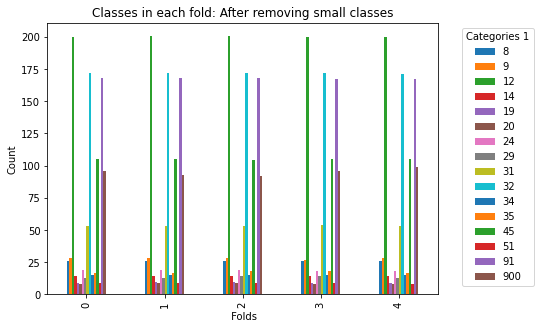

In [16]:
#Import stratifiedKFold to split the data equaly between folds
from sklearn.model_selection import StratifiedKFold

#Rename a copy of the dataset as folds
folds = df.copy()

#We will split the data between folds based on their 'category 1':
from sklearn import preprocessing
#Transformer the category 1 strings to encoded labels
le = preprocessing.LabelEncoder()
encode_cat1=le.fit(folds['Category 1'])
folds['Category 1']= encode_cat1.transform(folds['Category 1'])

#Split the dataset to N_FOLDS
Fold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['Category 1'])):
    folds.loc[val_index, 'fold'] = int(n)

    #Save the fold number as a new column
folds['fold'] = folds['fold'].astype(int)

#Rename 'Category 1' as 'label' for a easier workflow
folds=folds.rename(columns={'Category 1': 'label'})


#Select the categories that have less than 15 rows and store them in 'small_categories'
small_categories=folds['label'].value_counts()[15:].index.to_list()

#Rename all the small categories as 1 so they become a new category
#Replace them with a number that doesn't belong to the list of the TOP 15 categories. For ex: 900
folds['label'] = folds['label'].replace(small_categories,900)

#Plot the distribution of data per folds based on 'category 1'
dfu = folds.groupby(['fold']).label.value_counts().unstack()

# plot
dfu.plot.bar(figsize=(7, 5))
plt.legend(title='Categories 1', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Classes in each fold: After removing small classes')
plt.xlabel(' Folds')
plt.ylabel('Count')
plt.show()

Now we have all the categories distributed equally between the folds: Each fold has the same number of furniture items, DVD/Films... *(table below)*

In [17]:
dfu

label,8,9,12,14,19,20,24,29,31,32,34,35,45,51,91,900
fold,,,,,,,,,,,,,,,,
0,26,28,200,14,9,8,19,13,53,172,15,17,105,9,168,96
1,26,28,201,14,10,9,19,13,53,172,15,17,105,9,168,93
2,26,28,201,14,10,9,19,14,53,172,15,18,104,9,168,92
3,26,27,200,14,9,8,18,14,54,172,15,18,105,9,167,96
4,26,28,200,14,9,8,18,13,53,171,15,17,105,8,167,99


## One hot Encoding Categorical Variables
Here we will create one hot encoded columns for the categorical features: `Currency`, `category 1`, `category 2`, and `Hierarchy`.
* We will drop the `Date` column, we will not need it in modeling
* In addition to the one hot encoded categorical features, we will use the numrical features `Days` and `Starting Bid`

In [18]:
from sklearn import preprocessing
#Transformer the category 1 strings to encoded labels
le = preprocessing.LabelEncoder()

dummies=folds.copy()
encode_cur=le.fit(dummies['Currency'])
dummies['Currency']= encode_cur.transform(dummies['Currency'])

encode_cat2=le.fit(dummies['Category 2'])
dummies['Category 2']= encode_cat2.transform(dummies['Category 2'])

encode_hier=le.fit(dummies['Hierarchy'])
dummies['Hierarchy']= encode_hier.transform(dummies['Hierarchy'])

###SAVE encoders
joblib.dump(encode_cat1, 'encode_cat1.joblib')
joblib.dump(encode_cat2, 'encode_cat2.joblib')
joblib.dump(encode_cur, 'encode_cur.joblib')
joblib.dump(encode_hier, 'encode_hier.joblib')

['encode_hier.joblib']

In [19]:
dummies=dummies.drop(['index','Unnamed: 0','Auction Name','Date', 'fold', 'Winning Bid' ], axis=1)

In [20]:
#Add the fold, label and Winning Bid columns to our preprocessed text data
df2['fold']=folds['fold']
df2['label']=folds['label']
df2['Winning Bid']=folds['Winning Bid']


#Loop and train the model the number of folds
for fold in range(N_FOLDS):
    
    print(f'Fold {fold}')
    
    trn_idx = df2[df2['fold'] == fold].index #Get the index number of the training rows
    train_ = df2.loc[trn_idx,:].reset_index(drop=True) #Select the training rows from text
    dummy_tr= dummies.loc[trn_idx,:].reset_index(drop=True) #Select the training rows from dummies
    
    val_idx = df2[df2['fold'] != fold].index #Get the index number of the validation rows
    val_ = df2.loc[val_idx,:].reset_index(drop=True) #Select the validation rows from text
    dummy_val= dummies.loc[val_idx,:].reset_index(drop=True) ##Select the validation rows from dummies

    #We fit the tfv (TfidVectorizer) to convert our text data to vectors
    tfv_f=tfv.fit(list(train_['text_lemmatized']), list(val_['text_lemmatized']))
    joblib.dump(tfv_f, 'tfv_f.joblib')

    
    
    #Transform our text to vectors with tfv
    xtrain_tfv =  tfv_f.transform(train_['remove_emoji']) 
    xtest_tfv =  tfv_f.transform(val_['remove_emoji'])
    
    if use_catogerical_features:
        #Create a dataframe from the training text vectors and merge them with the categorical features
        xtrain_tfv = pd.DataFrame(xtrain_tfv.toarray())
        xtrain_tfv = pd.concat([xtrain_tfv, dummy_tr], axis=1)
        
        #Create a dataframe from the validation text vectors and merge them with the categorical features
        xtest_tfv = pd.DataFrame(xtest_tfv.toarray())
        xtest_tfv = pd.concat([xtest_tfv, dummy_val], axis=1)
    
    
    #Set the target: Winning Bid for train and test
    ytrain=train_['Winning Bid']
    y_test=val_['Winning Bid']
    
    
    #Log transform the target
    ytrain = np.log1p(ytrain)
    y_test = np.log1p(y_test)
    
    
    ########## FIRST MODEL/ LinearRegression
    from sklearn.linear_model import LinearRegression
    clf = LinearRegression()
    clf.fit(xtrain_tfv, ytrain)
    
    preds=clf.predict(xtest_tfv)
    print(f'Linear model: {score(preds)}')
    
    
    ########### SECOND MODEL: LASSO
    from sklearn.linear_model import Lasso
    import sklearn.model_selection as ms
    lasso_mod=Lasso(alpha=1)
    lasso_mod.fit(xtrain_tfv,ytrain)
    
    lasso_pred=lasso_mod.predict(xtest_tfv)
    print(f'Lasso model: {score(lasso_pred)}')
    
    
    ######## THIRD MODEL: ELASTICNET
    from sklearn.linear_model import ElasticNetCV
    alphas = [0.001]
    l1ratio = [0.1]
    elastic_cv = ElasticNetCV(cv=5, max_iter=1e7, alphas=alphas,  l1_ratio=l1ratio)
    elasticmod = elastic_cv.fit(xtrain_tfv,ytrain.ravel())
    
    ela_pred=elasticmod.predict(xtest_tfv)
    print(f'Elastic net: {score(ela_pred)}')
  
    
    ######## FOURTH MODEL: RIDGE
    import sklearn.model_selection as GridSearchCV
    from sklearn.linear_model import Ridge
    ridge_mod=Ridge(alpha=0.8)
    ridge_mod.fit(xtrain_tfv,ytrain)
    
    ridge_pred=ridge_mod.predict(xtest_tfv)
    print(f'Ridge: {score(ridge_pred)}')
    
    
    
    ####### FIFTH AND BEST MODEL: XGBoost
    from xgboost.sklearn import XGBRegressor
    xgb= XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=4000,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0.0001, reg_lambda=0.01, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
    xgmod=xgb.fit(xtrain_tfv,ytrain)
    
    xg_pred=xgmod.predict(xtest_tfv)
    print(f'XGBoost: {score(xg_pred)}')
 
    
    ##### SAVE XGBoost model as pickle file to be loaded for the Web App
    #pickle.dump(xgmod, open(f'xgb_{fold}.pkl', 'wb'))
    joblib.dump(xgmod, f'xgb—{fold}.joblib')
    joblib.dump(ridge_mod, f'ridge_{fold}.joblib')
    
    print("------------------------------")

Fold 0
Linear model: 22710774.148818284
Lasso model: 1.4119899963512095
Elastic net: 0.7312477838652872
Ridge: 0.7268752754790684
XGBoost: 0.6476945861035258
------------------------------
Fold 1
Linear model: 6.637620886248687
Lasso model: 1.4163620161651436
Elastic net: 0.7352355133554779
Ridge: 0.7339003342719551
XGBoost: 0.6316158807267552
------------------------------
Fold 2
Linear model: 3.44450728538157
Lasso model: 1.4070653223737741
Elastic net: 0.7263378698383677
Ridge: 0.7233450871984146
XGBoost: 0.6512202620147359
------------------------------
Fold 3
Linear model: 5.799770041024599
Lasso model: 1.4149462855075388
Elastic net: 0.7256311148984355
Ridge: 0.7213443439922292
XGBoost: 0.6459297871686736
------------------------------
Fold 4
Linear model: 42.201898192910754
Lasso model: 1.4117662361195522
Elastic net: 0.726712831144217
Ridge: 0.7230207642931222
XGBoost: 0.6333116793861524
------------------------------


In [21]:
# We use np.expm1 to get the original numbers after we use log transform np.log1p during training
final=np.expm1(y_test)
final1=np.expm1(xg_pred)

#Verify the original and predicted Winning Bed
final_result={'Winning Bid': final, 'Prediction': final1}
final_results=pd.DataFrame(final_result)
final_results.head(10)

,Winning Bid,Prediction
0,405.10,43.926903
1,154.85,119.105682
2,921.85,52.490425
3,632.00,43.360867
4,946.00,188.024323
5,780.00,45.304634
6,56.00,31.524982
7,59.00,42.729588
8,990.00,137.902206
9,155.00,119.105682
